In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import time
import random

%matplotlib inline

In [2]:
# Function definitions

def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

### HTTP/SMTP Dataset

In [3]:
# Load http-smtp data
X = pd.read_csv('data/http_smtp.csv')
X.service = LabelEncoder().fit_transform(X.service)
service_names = ['http','smtp']

# Keep just http
X = X[X.service == 0]
X.drop('service', axis=1, inplace=True)
X.head()

,log_duration,log_src_bytes,log_dst_bytes,outlier
0,-2.3026,5.3711,10.7160,0
1,-2.3026,5.0882,8.4181,0
2,-2.3026,5.4643,7.1132,0
3,-2.3026,5.4515,7.6168,0
4,-2.3026,5.4769,6.1864,0


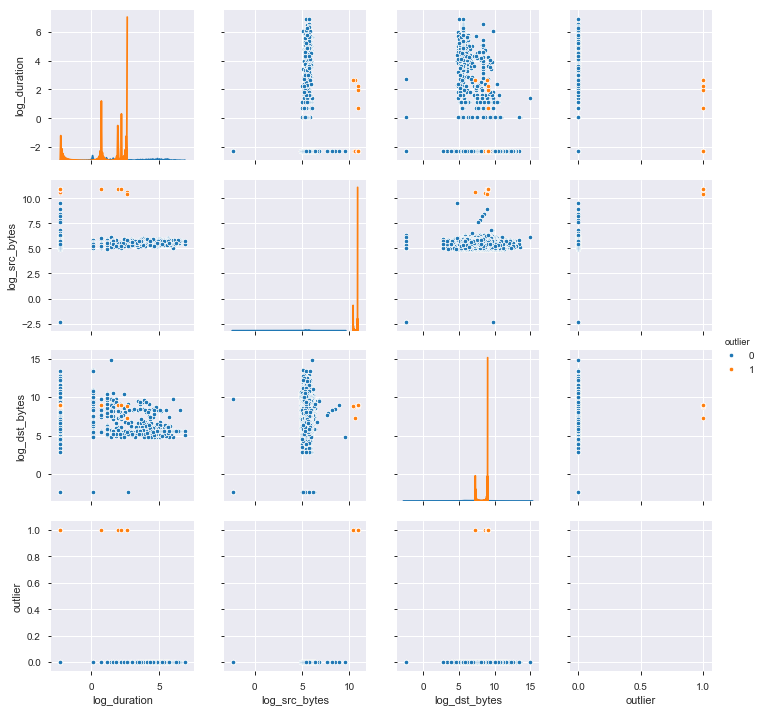

In [8]:
# Look at data
samp_size = 10**5
rand_samp = random.sample(list(range(0, X.shape[0])),samp_size)
sns.pairplot(X.iloc[rand_samp], hue='outlier',plot_kws=dict(s=20))

In [4]:
# Drop label column

y = X['outlier']
X.drop('outlier', axis=1, inplace=True)

#### Isolation Forest

In [61]:
# Run isolation Forest
from sklearn.ensemble import IsolationForest

start = time.time()
clf = IsolationForest(behaviour = 'new', max_samples=100, 
                      random_state = 1, contamination = 'auto')
clf.fit(X)
anomaly_scores = clf.decision_function(X)
end = time.time()

print('Run time: %.4f sec' %(end-start))

Run time: 23.0579 sec


In [62]:
# Show results
thresh = -0.17 # given that the model was run with contamination = 'auto', a score 
               # of 0 is corresponds to above 20% of scores 
out_pred = (anomaly_scores<thresh).astype('int')

sensitivity = np.sum(np.logical_and(y==1,out_pred==1))/np.sum(y==1)
specificity = np.sum(np.logical_and(y==0,out_pred==0))/np.sum(y==0)
auc = sk.metrics.roc_auc_score(y,-anomaly_scores)

print('Detected %d (of %d) anomalies' %(np.sum(out_pred), np.sum(y)))
print('AUC = \t\t%f \nsensitivity = \t%.3f \nspecificity = \t%.3f' %(auc, sensitivity, specificity))

Detected 4882 (of 2211) anomalies
AUC = 		0.996464 
sensitivity = 	0.982 
specificity = 	0.995


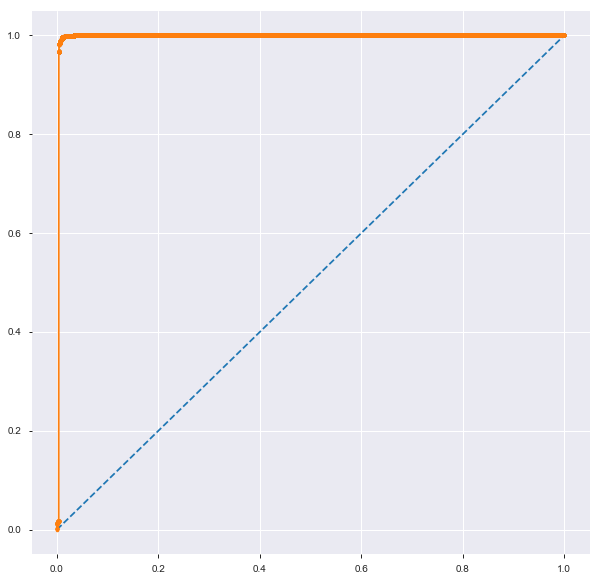

In [44]:
# Plot ROC curve
fpr, tpr, thresholds = sk.metrics.roc_curve(y, -anomaly_scores)
plt.figure(figsize=[10,10])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show;

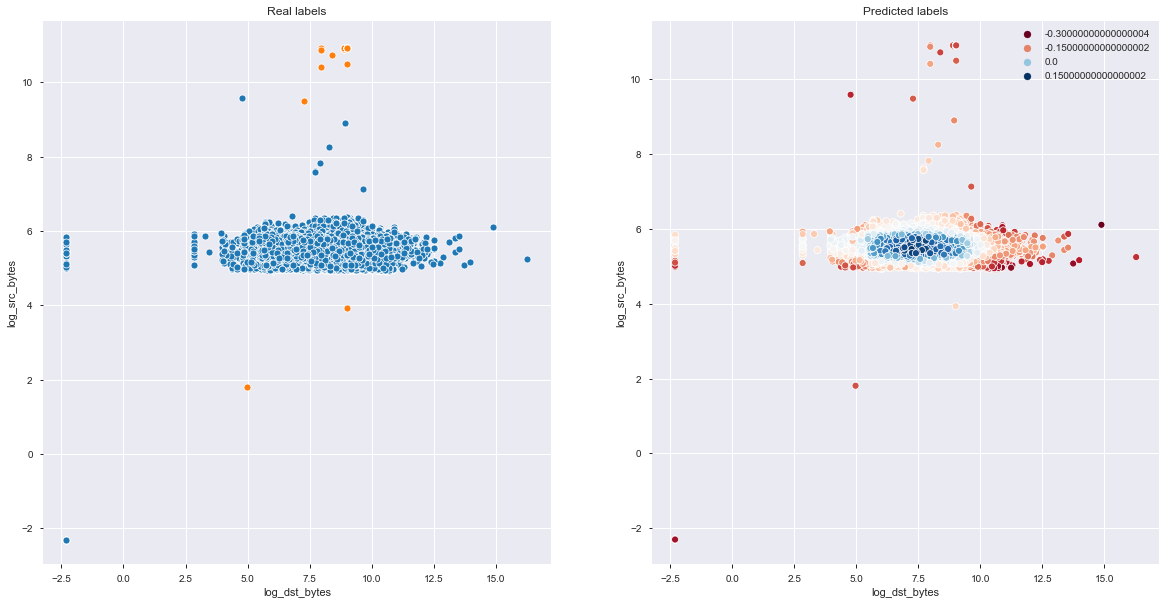

In [61]:
# Plot labeled and predicted outliers on a two-feature space
columns = ['log_dst_bytes','log_src_bytes']
num_rand_samples = 10**5
idx = (np.random.rand(num_rand_samples)*len(y)).astype('int')
tempX = X.iloc[idx]
tempy = y[idx]
temppred = out_pred[idx]
tempscores = anomaly_scores[idx]

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
plt.title('Real labels')
sns.scatterplot(tempX[tempy==0][columns[0]], tempX[tempy==0][columns[1]]);
sns.scatterplot(tempX[tempy==1][columns[0]], tempX[tempy==1][columns[1]]);
plt.subplot(1,2,2)
plt.title('Predicted labels')
sns.scatterplot(tempX[columns[0]], tempX[columns[1]], hue=tempscores, palette='RdBu');


#### DBScan

In [5]:
# Z-transform all columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
columns = X.columns
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = columns

In [6]:
# Take a smaller subset
num_rand_samples = 10**5
idx = (np.random.rand(num_rand_samples)*len(y)).astype('int')
X2 = X.iloc[idx]
X2.columns = X.columns
y2 = y[idx]

In [7]:
# run DBScan

from sklearn.cluster import DBSCAN

start = time.time()
outlier_detection = DBSCAN(min_samples = 5, eps = 0.01)
clusters = outlier_detection.fit_predict(X2)
end = time.time()

print('Run time: %.4f sec' %(end-start))

Run time: 8.0028 sec


In [8]:
# Show results
out_pred = (clusters==-1).astype('int')

auc = sk.metrics.roc_auc_score(y2, out_pred)
sensitivity = np.sum(np.logical_and(y2==1,out_pred==1))/np.sum(y2==1)
specificity = np.sum(np.logical_and(y2==0,out_pred==0))/np.sum(y2==0)


print('detected %d (of %d) anomalies. AUC = %f, sensitivity = %.3f, specificity = %.3f.' %(np.sum(out_pred), np.sum(y), auc, sensitivity, specificity))

detected 22706 (of 2211) anomalies. AUC = 0.401308, sensitivity = 0.031, specificity = 0.772.


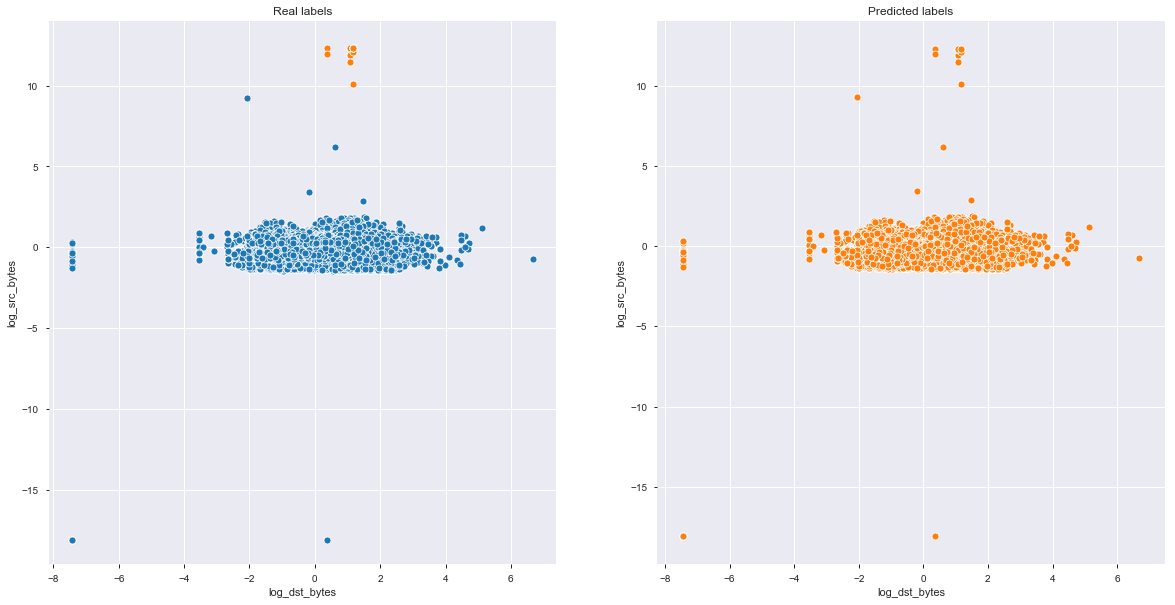

In [9]:
# Plot labeled and predicted outliers on a two-feature space
columns = ['log_dst_bytes','log_src_bytes']

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
plt.title('Real labels')
sns.scatterplot(X2[y2==0][columns[0]], X2[y2==0][columns[1]]);
sns.scatterplot(X2[y2==1][columns[0]], X2[y2==1][columns[1]]);
plt.subplot(1,2,2)
plt.title('Predicted labels')
sns.scatterplot(X2[out_pred==0][columns[0]], X2[out_pred==0][columns[1]]);
sns.scatterplot(X2[out_pred==1][columns[0]], X2[out_pred==1][columns[1]]);
# sns.scatterplot(X2[columns[0]], X2[columns[1]], hue=clusters, palette='RdBu', hue_norm=(-1,10));
